In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import MNIST

In [21]:
version = 2
save_dir = "models"
os.makedirs(save_dir, exist_ok=True)
model_path = os.path.join(save_dir, f"cnn_model_{version}.pth")

## Define Model

In [32]:
# Define a lightweight CNN architecture
class LightweightCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(LightweightCNN, self).__init__()

        # First convolutional block
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, stride=3, padding=1) # stride = 2, padding = 0
        self.bn1 = nn.BatchNorm2d(8)
        self.pool1 = nn.MaxPool2d(2, 2)

        # Second convolutional block
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(16)
        self.pool2 = nn.MaxPool2d(2, 2)

        # Third convolutional block
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(32)
        self.pool3 = nn.MaxPool2d(2, 2)

        # Fully connected layers
        self.fc1 = nn.Linear(32 * 1 * 1, 128)  # 64 * 1 * 1, 128
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        # Flatten and fully connected layers
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x


## Initialize Model

In [33]:
def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, mean=0.0, std=0.01)  # smaller std for large inputs
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

In [34]:
# Initialize the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LightweightCNN(num_classes=10).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

print(f"Model created on device: {device}")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")


Model created on device: cpu
Total parameters: 11,514


## Load Data

In [35]:
transform = transforms.Compose([
    transforms.Lambda(lambda pic: torch.tensor(np.array(pic), dtype=torch.float32).unsqueeze(0))
])

# Load training and test datasets
train_dataset = MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = MNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Training samples: 60000
Test samples: 10000


## Train model

In [36]:
# Training function
def train_model(model, train_loader, criterion, optimizer, device, epochs=5):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()

            if batch_idx % 200 == 0:
                print(f'Epoch {epoch + 1}/{epochs}, Batch {batch_idx}/{len(train_loader)}, '
                      f'Loss: {loss.item():.4f}, Accuracy: {100. * correct / total:.2f}%')

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100. * correct / total
        print(f'Epoch {epoch + 1} completed - Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%')
        print('-' * 50)


# Train the model
print("Starting training...")
train_model(model, train_loader, criterion, optimizer, device, epochs=3)


Starting training...
Epoch 1/3, Batch 0/938, Loss: 2.3007, Accuracy: 15.62%
Epoch 1/3, Batch 200/938, Loss: 0.8082, Accuracy: 48.30%
Epoch 1/3, Batch 400/938, Loss: 0.3108, Accuracy: 62.73%
Epoch 1/3, Batch 600/938, Loss: 0.4805, Accuracy: 69.87%
Epoch 1/3, Batch 800/938, Loss: 0.3167, Accuracy: 74.34%
Epoch 1 completed - Loss: 0.7402, Accuracy: 76.31%
--------------------------------------------------
Epoch 2/3, Batch 0/938, Loss: 0.4995, Accuracy: 85.94%
Epoch 2/3, Batch 200/938, Loss: 0.2025, Accuracy: 89.70%
Epoch 2/3, Batch 400/938, Loss: 0.4701, Accuracy: 89.96%
Epoch 2/3, Batch 600/938, Loss: 0.3104, Accuracy: 90.25%
Epoch 2/3, Batch 800/938, Loss: 0.2989, Accuracy: 90.44%
Epoch 2 completed - Loss: 0.3098, Accuracy: 90.58%
--------------------------------------------------
Epoch 3/3, Batch 0/938, Loss: 0.1614, Accuracy: 92.19%
Epoch 3/3, Batch 200/938, Loss: 0.2591, Accuracy: 92.04%
Epoch 3/3, Batch 400/938, Loss: 0.7188, Accuracy: 92.18%
Epoch 3/3, Batch 600/938, Loss: 0.2491, 

## Test Model

In [37]:
# Test the model
def test_model(model, test_loader, device):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()

    test_loss /= len(test_loader)
    accuracy = 100. * correct / total

    print(f'Test Loss: {test_loss:.4f}')
    print(f'Test Accuracy: {accuracy:.2f}%')

    return accuracy


# Evaluate the trained model
print("Evaluating model on test set...")
test_accuracy = test_model(model, test_loader, device)


Evaluating model on test set...
Test Loss: 0.1826
Test Accuracy: 94.10%


Visualizing some predictions...


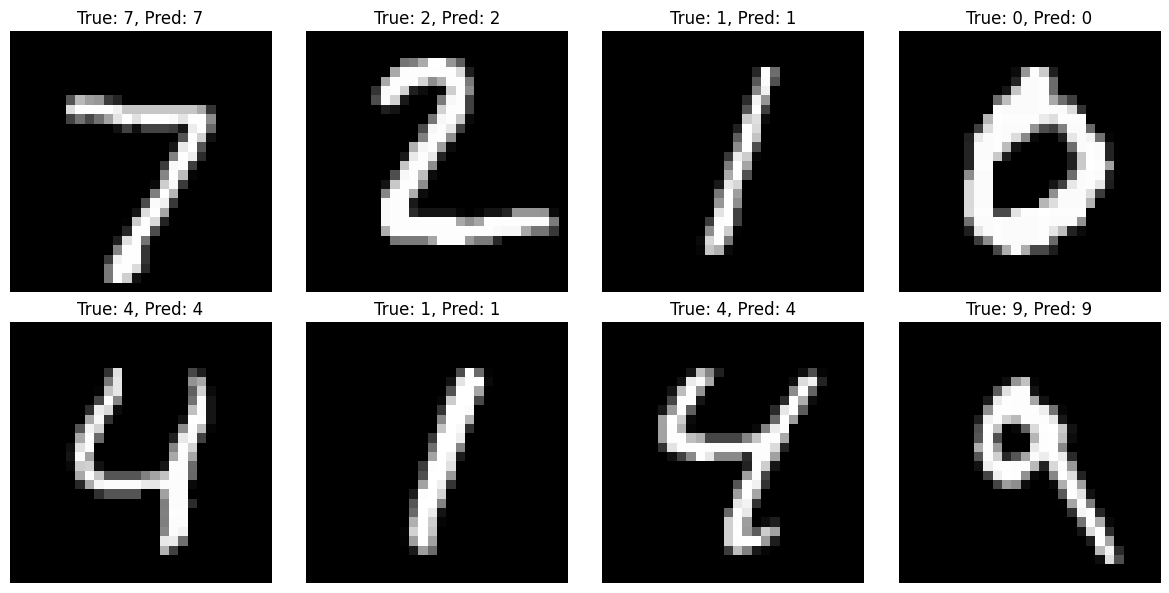

In [38]:
# Visualize some predictions
def visualize_predictions(model, test_loader, device, num_samples=8):
    model.eval()
    with torch.no_grad():
        # Get a batch of test data
        data_iter = iter(test_loader)
        images, labels = next(data_iter)
        images, labels = images.to(device), labels.to(device)

        # Get predictions
        outputs = model(images)
        _, predicted = outputs.max(1)

        # Move back to CPU for visualization
        images = images.cpu()
        labels = labels.cpu()
        predicted = predicted.cpu()

        img = images[0]

        img_np = img.squeeze().numpy()  # remove channel dimension

        # Create subplot
        fig, axes = plt.subplots(2, 4, figsize=(12, 6))
        axes = axes.ravel()

        for i in range(num_samples):
            axes[i].imshow(images[i].squeeze(), cmap='gray')
            axes[i].set_title(f'True: {labels[i].item()}, Pred: {predicted[i].item()}')
            axes[i].axis('off')

        plt.tight_layout()
        plt.show()


# Visualize predictions
print("Visualizing some predictions...")
visualize_predictions(model, test_loader, device)


## Save Model

In [39]:
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

Model saved to models\cnn_model_2.pth
